# Dogecoin Time-Series Analysis

### Set up environment

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Acquire and summarize data

Using daily-sampled historical data on Dogecoin to USD value from Investing.com.

In [2]:
df = pd.read_csv('DogecoinHistoricalTruncated.csv')

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 05, 2021",0.049016,0.052898,0.052898,0.049016,51.96B,-7.39%
1,"Feb 04, 2021",0.052930,0.037000,0.052930,0.036789,48.78B,41.69%
2,"Feb 03, 2021",0.037356,0.031388,0.037356,0.031388,12.96B,19.17%
3,"Feb 02, 2021",0.031347,0.034816,0.034816,0.030692,11.55B,-9.65%
4,"Feb 01, 2021",0.034694,0.036722,0.040650,0.034694,23.87B,-5.69%


In [4]:
# convert date column to datetime type
df.Date = pd.to_datetime(df.Date)
df.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                object
Change %            object
dtype: object

In [5]:
# set ds as index and sort
# this is a very important step!
df = df.set_index('Date').sort_index()
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-01,0.003323,0.003558,0.003568,0.003323,1.03B,-6.67%
2020-12-02,0.003368,0.003324,0.003404,0.003324,591.00M,1.35%
2020-12-03,0.003428,0.003363,0.003439,0.003363,662.66M,1.78%
2020-12-04,0.003284,0.003422,0.003422,0.003284,572.32M,-4.20%
2020-12-05,0.003392,0.003281,0.003404,0.003281,369.45M,3.28%


Now that the data is acquired, let's look at its data types and summary statistics.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2020-12-01 to 2021-02-05
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     67 non-null     float64
 1   Open      67 non-null     float64
 2   High      67 non-null     float64
 3   Low       67 non-null     float64
 4   Vol.      67 non-null     object 
 5   Change %  67 non-null     object 
dtypes: float64(4), object(2)
memory usage: 3.7+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,67.0,0.010672,0.011989,0.003073,0.003743,0.008076,0.009742,0.052930
Open,67.0,0.009973,0.010959,0.003073,0.003638,0.007405,0.009579,0.052898
High,67.0,0.011812,0.014410,0.003113,0.003909,0.008351,0.009995,0.071812
Low,67.0,0.009213,0.009641,0.003058,0.003556,0.006835,0.009075,0.049016


In [8]:
df.shape

(67, 6)

### Prepare the data

Rename columns for readability and ease of calling.

In [9]:
df = df.rename(columns={'Vol.' : 'Volume'})
df = df.rename(columns={'Change %' : 'PercentChange'})

Appropriately convert strings to numericals.

In [10]:
df.head()

,Price,Open,High,Low,Volume,PercentChange
Date,,,,,,
2020-12-01,0.003323,0.003558,0.003568,0.003323,1.03B,-6.67%
2020-12-02,0.003368,0.003324,0.003404,0.003324,591.00M,1.35%
2020-12-03,0.003428,0.003363,0.003439,0.003363,662.66M,1.78%
2020-12-04,0.003284,0.003422,0.003422,0.003284,572.32M,-4.20%
2020-12-05,0.003392,0.003281,0.003404,0.003281,369.45M,3.28%


In [11]:
def mb_to_mbillion(string):
    if string[-1] == 'B':
        string = string[:-1]
        num = float(string) * 1_000_000_000
    elif string[-1] == 'M':
        string = string[:-1]
        num = float(string) * 1_000_000
    return num

df.Volume = df.Volume.apply(mb_to_mbillion)

In [12]:
def handle_percent(string):
    string = string[:-1]
    num = float(string)
    return num

df.PercentChange = df.PercentChange.apply(handle_percent)

In [13]:
df.dtypes

Price            float64
Open             float64
High             float64
Low              float64
Volume           float64
PercentChange    float64
dtype: object

In [14]:
df.head()

,Price,Open,High,Low,Volume,PercentChange
Date,,,,,,
2020-12-01,0.003323,0.003558,0.003568,0.003323,1.030000e+09,-6.67
2020-12-02,0.003368,0.003324,0.003404,0.003324,5.910000e+08,1.35
2020-12-03,0.003428,0.003363,0.003439,0.003363,6.626600e+08,1.78
2020-12-04,0.003284,0.003422,0.003422,0.003284,5.723200e+08,-4.20
2020-12-05,0.003392,0.003281,0.003404,0.003281,3.694500e+08,3.28


Conversions successful.

### Acquire minute OHLCV data

After I split the data and plotted it, I realized that there is not enough data to split how I want, as this dataset is only daily.

So, I am now going to acquire minute-by-minute Dogecoin/USD data. It's a little messier than the other dataset, but the time and effort will be well worth it.

In [31]:
df = pd.read_csv('DOGEBUSD.csv', header=None, sep='|')
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1596085200,0.003158,0.003158,0.003158,0.003158,3200,10,3200,10,1
1,1596085260,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0
2,1596085320,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0
3,1596085380,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0
4,1596085440,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0


There was no documentation I could find on what each column represents.

However, I can use domain knowledge and process of eliminaton to make educated guesses on which columns are what.

In [36]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.711560e+05,271156.000000,271156.000000,271156.000000,271156.000000,2.711560e+05,2.711560e+05,2.711560e+05,2.711560e+05,271156.000000
mean,1.604225e+09,0.005055,0.005067,0.005042,0.005055,1.195681e+05,1.502850e+03,6.173845e+04,2.999772e+03,7.722993
std,4.703335e+06,0.006318,0.006381,0.006252,0.006318,7.719368e+05,1.470506e+04,4.140371e+05,2.776896e+04,59.216036
min,1.596085e+09,0.002459,0.002459,0.002459,0.002459,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.600153e+09,0.002714,0.002715,0.002714,0.002714,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.604220e+09,0.003255,0.003255,0.003255,0.003255,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
75%,1.608291e+09,0.003907,0.003907,0.003906,0.003907,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
max,1.612376e+09,0.085995,0.087381,0.083201,0.085995,4.248405e+07,1.403784e+06,2.364880e+07,1.908171e+06,3431.000000


In [ ]:
# rename columns

col_dict = {
    0: 'SecondsSinceEpoch',
    1: 'Open',
    2: 'High',
    3: 'Low',
    4: 'Close',
    5: 'Volume'
}



### Prepare minute data

### Split the data

Now I will split the dataset into train, validate, and test since the goal of this project is to create a predictive model.

In [15]:
# get size of train
train_size = int(len(df) * .90)
train_size

60

In [16]:
# get size of validate
validate_size = int(len(df) * .08)
validate_size

5

In [17]:
# get size of test
test_size = int(len(df) - train_size - validate_size)
test_size

2

In [18]:
# get end index of validate
validate_end_index = train_size + validate_size
validate_end_index

65

In [19]:
# use the above values to split the df
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

Now to verify the splits.

In [20]:
# Does the length of each df equate to the length of the original df?

print(len(train) + len(validate) + len(test) == len(df))

True


In [21]:
# Does the first row of original df equate to the first row of train?

print(df.head(1) == train.head(1))

            Price  Open  High   Low  Volume  PercentChange
Date                                                      
2020-12-01   True  True  True  True    True           True


In [22]:
# Is the last row of train the day before the first row of validate? And the same for validate to test?

pd.concat([train.tail(1), validate.head(1)])

,Price,Open,High,Low,Volume,PercentChange
Date,,,,,,
2021-01-29,0.046723,0.035574,0.071812,0.034355,1.091500e+11,29.07
2021-01-30,0.028243,0.045875,0.045968,0.023731,5.458000e+10,-39.55


In [23]:
pd.concat([validate.tail(1), test.head(1)])

,Price,Open,High,Low,Volume,PercentChange
Date,,,,,,
2021-02-03,0.037356,0.031388,0.037356,0.031388,1.296000e+10,19.17
2021-02-04,0.052930,0.037000,0.052930,0.036789,4.878000e+10,41.69


In [24]:
# Is the last row of test the same as the last row of our original dataframe?

pd.concat([test.tail(1), df.tail(1)])

,Price,Open,High,Low,Volume,PercentChange
Date,,,,,,
2021-02-05,0.049016,0.052898,0.052898,0.049016,5.196000e+10,-7.39
2021-02-05,0.049016,0.052898,0.052898,0.049016,5.196000e+10,-7.39


Splits successful. Onward to data exploration.

### Exploratory data analysis

First I'll plot the data, viewing where the data is split into train and test.

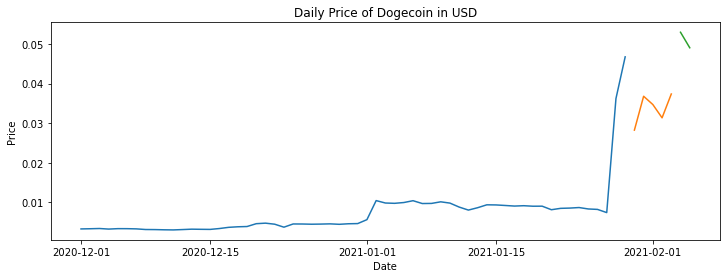

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train['Price'])
plt.plot(validate['Price'])
plt.plot(test['Price'])
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Daily Price of Dogecoin in USD')
plt.show()